In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import xarray as xr
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import dataframe_image as dfi
import sys
sys.path.insert(0, '/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability')
import tool_box

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)


def correlation_matrix_creator(predictors_and_target_df):
    predictors_and_target_df = predictors_and_target_df.to_numpy()
    corr_matrx = []
    for ts_1 in range(len(predictors_and_target_df.T)):
        corr_row = []
        for ts_2 in range(len(predictors_and_target_df.T)):
            timeseries_1 = predictors_and_target_df[:,ts_1]
            timeseries_2 = predictors_and_target_df[:,ts_2]
            N = len(timeseries_1)
            r = stats.pearsonr(timeseries_1[:], timeseries_2[:])[0]
            r1_autocorrelation = stats.pearsonr(timeseries_1[1:], timeseries_1[:-1])[0]
            r2_autocorrelation = stats.pearsonr(timeseries_2[1:], timeseries_2[:-1])[0]
            N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                        (1+r1_autocorrelation*r2_autocorrelation))
            tcrit = stats.t.ppf(1-0.025, N_star)
            t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
            if abs(t) - tcrit > 0:
                significant = 1
            else:
                significant = 0
            corr_row.append([r, significant])
        corr_matrx.append(corr_row)
    return np.array(corr_matrx)

def corr_matrix_plotter(corr_matrx):
    correlation_matrix = corr_matrx[:,:,0]
    correlation_matrix = np.around(correlation_matrix, 2)
    significance_matrix = corr_matrx[:,:,1] 

    # Significance will be dictated in Correlation Matrix with '*'
    sig_str = []
    for row in significance_matrix:
        row_str = []
        for item in row:
            if int(item) == 1:
                row_str.append('*')
            else:
                row_str.append(' ')
        sig_str.append(row_str)
    sig_str = np.array(sig_str)

    corr = correlation_matrix.astype(str)
    matrix = np.triu(np.ones_like(corr_matrx))
    plt.figure(figsize=(len(correlation_matrix),len(correlation_matrix)))
    sns.set_palette("Paired")
    sns.color_palette("Paired")


    # combining text with values
    formatted_text = (np.asarray(["{corr}{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())])).reshape(len(correlation_matrix), len(correlation_matrix))
    #formatted_text = (print(np.asarray(["{corr}\n{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())]))).reshape(8, 8)

    # plot the heatmap
    matrix = np.triu(np.ones_like(significance_matrix))
    ax = sns.heatmap(correlation_matrix, xticklabels=predictors_and_target_df.columns, 
                yticklabels=predictors_and_target_df.columns, cmap=custom_cmap, 
                annot=formatted_text,  vmin=-1, vmax=1, fmt="",
                annot_kws={"fontsize":12}, mask=matrix, cbar=False)
    for i in range(0, len(matrix)-1):
        for j in range(1, len(matrix[i])):
            if int(matrix[i,j]) == 0:
                continue
            elif i == j:
                continue
            else:
                ax.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='black', lw=1.5))
    return(ax)
    
def lr_table(X, Y1, Y2, Y3, Y4, Y5):
    X = sm.add_constant(X) # adding a constant
    
    lm1 = pg.linear_regression(X, Y1, add_intercept=True, relimp=True)
    lm1 = lm1[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm1 = lm1.round(2)
    r2_y1 = lm1.r2[0]
    adjr2_y1 = lm1.adj_r2[0]
    #################################################################
    lm2 = pg.linear_regression(X, Y2, add_intercept=True, relimp=True)
    lm2 = lm2[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm2 = lm2.round(2)
    r2_y2 = lm2.r2[0]
    adjr2_y2 = lm2.adj_r2[0]
    #################################################################
    lm3 = pg.linear_regression(X, Y3, add_intercept=True, relimp=True)
    lm3 = lm3[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm3 = lm3.round(2)
    r2_y3 = lm3.r2[0]
    adjr2_y3 = lm3.adj_r2[0]
    #################################################################
    lm4 = pg.linear_regression(X, Y4, add_intercept=True, relimp=True)
    lm4 = lm4[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm4 = lm4.round(2)
    r2_y4 = lm4.r2[0]
    adjr2_y4 = lm4.adj_r2[0]
    #################################################################
    lm5 = pg.linear_regression(X, Y5, add_intercept=True, relimp=True)
    lm5 = lm5[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm5 = lm5.round(2)
    r2_y5 = lm5.r2[0]
    adjr2_y5 = lm5.adj_r2[0]
    
    new_df = [
              ['  CPT  ', str(lm1.coef[1]) + '/' + str(lm1.relimp[1]), str(lm1.coef[2]) + '/' +  str(lm1.relimp[2]), str(lm1.coef[3]) + '/' +  str(lm1.relimp[3]), r2_y1, adjr2_y1], 
              ['  CPZ  ', str(lm5.coef[1]) + '/' + str(lm5.relimp[1]), str(lm5.coef[2]) + '/' +  str(lm5.relimp[2]), str(lm5.coef[3]) + '/' +  str(lm5.relimp[3]), r2_y5, adjr2_y5], 
              ['  WV  ',str(lm3.coef[1]) + '/' + str(lm3.relimp[1]), str(lm3.coef[2]) + '/' +  str(lm3.relimp[2]), str(lm3.coef[3]) + '/' +  str(lm3.relimp[3]), r2_y3, adjr2_y3],
              ['  TCF  ',str(lm2.coef[1]) + '/' + str(lm2.relimp[1]), str(lm2.coef[2]) + '/' +  str(lm2.relimp[2]), str(lm2.coef[3]) + '/' +  str(lm2.relimp[3]), r2_y2, adjr2_y2],
              ['  ACF  ',str(lm4.coef[1]) + '/' + str(lm4.relimp[1]), str(lm4.coef[2]) + '/' +  str(lm3.relimp[2]), str(lm4.coef[3]) + '/' +  str(lm4.relimp[3]), r2_y4, adjr2_y4]]
    
    new_df = pd.DataFrame(new_df)
    new_df.columns = ['       ', ' QBO ', ' BDC ', ' ENSO ', 'R2', 'adj R2']    
    table_text = new_df.to_latex(index=False, na_rep='NA')
    #table_text_w_caption = table_text[:19] + '\n\caption {$R^{2}$ = } \label{tab:title} ' + table_text[19:]
    print(table_text)

def cf_profile_finder(cf_prof_maps):
    cf_prof_maps_ = np.sort(cf_prof_maps)
    profile_cf = np.array([np.load(cf_prof_maps_[yr])[0] for yr in range(len(cf_prof_maps_))])
    empty_prof_map = np.empty(np.shape(profile_cf[:5]))
    empty_prof_map[:] = np.NaN
    profile_cf = np.concatenate((empty_prof_map, profile_cf), axis=0)
    profile_cf = np.reshape(profile_cf, (15,12,24,144,221))
    profile_cf[10,1] = np.nanmean([profile_cf[10,0], profile_cf[10,2]], axis=0)
    profile_cf_anoms = profile_cf - np.nanmean(profile_cf, axis=0)
    profile_cf_anoms_zm = np.nanmean(np.reshape(profile_cf_anoms, (15,12,24*144,221)), axis=2)
    return(profile_cf_anoms_zm)

def season_finder(calendar, m1, m2, m3, m4, m5):
    """ 
    Data should be indexed as (years, months)
    """
    total_djf_anoms_list = [calendar[:,m1], calendar[:,m2], 
                            calendar[:,m3], calendar[:,m4],
                            calendar[:,m5]]
    total_djf_anoms = np.swapaxes(total_djf_anoms_list, 0,1)
    shape = np.shape(total_djf_anoms)
    total_djf_timeseries = np.reshape(total_djf_anoms, (shape[0]*shape[1]))
    return(total_djf_timeseries)

def season_finder_profiles(calendar, m1, m2, m3, m4, m5):
    """ 
    Data should be indexed as (years, months)
    """
    total_djf_anoms_list = [calendar[:,m1], calendar[:,m2], 
                            calendar[:,m3], calendar[:,m4],
                            calendar[:,m5]]
    total_djf_anoms = np.swapaxes(total_djf_anoms_list, 0,1)
    shape = np.shape(total_djf_anoms)
    total_djf_timeseries = np.reshape(total_djf_anoms, (shape[0]*shape[1],shape[2]))
    return(total_djf_timeseries)

def seasonal_mlr_by_height(targets, predictors):
    """
    targets should be an array with: [TTL cirrus, All cf, other 
                                      cirrus, opaque cirrus, temps, 
                                      water vapor]
    predictors should be: [ENSO, QBO, BDC]
    """

    r2_std_ttl = []
    r2_std_all = []
    r2_std_other = []
    r2_std_opaque = []
    r2_std_temp = []
    r2_std_wv = []

    profile_cf_tropical_mean = targets[0]
    profile_all_cf_anoms_zm = targets[1]
    profile_transparent_anoms_zm = targets[2]
    profile_opaque_anoms_zm = targets[3]
    temps_tropical_mean = targets[4]
    wv_tropical_mean = targets[5]

    enso = predictors[0]
    qbo = predictors[1]
    bdc = predictors[2]

    for height in range(0, 100):
        ttl_at_height = profile_cf_tropical_mean[:,height]
        all_at_height = profile_all_cf_anoms_zm[:,height + 120]
        other_at_height = profile_transparent_anoms_zm[:,height + 120]
        opaque_at_height = profile_opaque_anoms_zm[:,height + 120]
        temps_at_height = temps_tropical_mean[:,height]
        
        predictors_and_target = [temps_at_height, ttl_at_height, all_at_height, 
                                 other_at_height, opaque_at_height, enso, 
                                 qbo, bdc]
        predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                                columns=['TEMP','TTL', 'ALL', 'OTHER', 'OPAQUE',
                                                        'ENSO', 'QBO', 'BDC'])

        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['TTL']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_ttl.append([lsd_r2, np.nanstd(ttl_at_height)])
        ####################################
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['ALL']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_all.append([lsd_r2, np.nanstd(all_at_height)])
        ####################################
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['OTHER']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_other.append([lsd_r2, np.nanstd(other_at_height)])
        ####################################
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['OPAQUE']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_opaque.append([lsd_r2, np.nanstd(opaque_at_height)])
        ####################################
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['TEMP']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_temp.append([lsd_r2, np.nanstd(temps_at_height)])
        
    for height in range(6, 20):
        wv_at_height = wv_tropical_mean[:,height]
        predictors_and_target = [wv_at_height, enso, qbo, bdc]
        predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                                columns=['wv', 'ENSO', 'QBO', 'BDC'])
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['wv']
        ####################################
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_wv.append([lsd_r2, np.nanstd(wv_at_height)])

    r2_std_ttl = np.array(r2_std_ttl)
    r2_std_all = np.array(r2_std_all)
    r2_std_other = np.array(r2_std_other)
    r2_std_opaque = np.array(r2_std_opaque)
    r2_std_temp = np.array(r2_std_temp)
    r2_std_wv = np.array(r2_std_wv)

    return(r2_std_ttl, r2_std_all, r2_std_other,r2_std_opaque, r2_std_temp, r2_std_wv)

def r2_plotting(r2_std_ttl, r2_std_all, r2_std_other,r2_std_opaque, r2_std_temp, r2_std_wv, suptitle):
    heights = np.linspace(12,22, 100)
    pressures = [316.22775, 261.01572, 215.4434, 177.82794, 146.77992, 121.15276, 100., 
                82.54042, 68.1292, 56.23413, 46.41589, 38.311867, 31.622776, 26.101572]
    fig, axs = plt.subplots(1,2,figsize=(9,6))
    ####################################################################################
    axs[0].set_xlabel('$\sigma$', fontsize=14)
    axs[0].set_ylabel('Height (km)', fontsize=14)
    axs[0].plot(r2_std_all[:,1]*50, heights, label="All", color='blue', linewidth=2)
    axs[0].plot(r2_std_ttl[:,1]*50, heights, label="TTL", color='blue', linewidth=1, linestyle='--')
    axs[0].plot(r2_std_other[:,1]*50, heights, label="Other", color='blue', linewidth=1, linestyle='dotted')
    axs[0].plot(r2_std_opaque[:,1]*50, heights, label="Opaque", color='blue', linewidth=1, linestyle='dashdot')
    axs[0].plot(r2_std_temp[:,1], heights, label="WV", color='firebrick', linewidth=1.6)
    axs[0].plot(r2_std_temp[:,1], heights, label="Temp", color='black', linewidth=2)
    ax0y = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
    ax0y.plot(r2_std_wv[:,1]*1e6, pressures, label="Water Vapor", color='firebrick', linewidth=2)
    #ax0y.set_ylabel('Pressure (hPa)', color='black', fontsize=14)  # we already handled the x-label with axs[0]
    ax0y.tick_params(axis='y')

    axs[0].legend(frameon=False)
    axs[0].grid(color='grey', linestyle='-', linewidth=.5, alpha=.5)
    axs[0].set_ylim(12,21)
    axs[0].set_xlim(0,0.8)
    ax0y.set_xlim(0,2)
    ax0y.set_ylim(50,180)
    ax0y.set_ylim(ax0y.get_ylim()[::-1])
    ax0y.set_yscale('log')
    plt.title("Interannual Variability \nStandard Deviation", fontsize=14)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    ####################################################################################
    axs[1].set_xlabel('$R^{2}$', fontsize=14)
    #axs[1].set_ylabel('Height (km)', fontsize=14)
    axs[1].plot(r2_std_all[:,0], heights, label="All clouds", color='blue', linewidth=2)
    axs[1].plot(r2_std_ttl[:,0], heights, label="TTL cirrus", color='blue', linewidth=1, linestyle='--')
    axs[1].plot(r2_std_other[:,0], heights, label="Other clouds", color='blue', linewidth=1, linestyle='dotted')
    axs[1].plot(r2_std_opaque[:,0], heights, label="Opaque clouds", color='blue', linewidth=1, linestyle='dashdot')
    axs[1].plot(r2_std_temp[:,0], heights, label="WV", color='firebrick', linewidth=1.6)
    axs[1].plot(r2_std_temp[:,0], heights, label="Temp", color='black', linewidth=2)
    ax0y = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
    ax0y.plot(r2_std_wv[:,0], pressures, label="Water Vapor", color='firebrick', linewidth=2)
    ax0y.set_ylabel('Pressure (hPa)', color='black', fontsize=14)  # we already handled the x-label with axs[0]
    ax0y.tick_params(axis='y')

    #axs[1].legend(frameon=False)
    axs[1].grid(color='grey', linestyle='-', linewidth=.5, alpha=.5)
    axs[1].set_ylim(12,21)
    axs[1].set_xlim(0,0.8)
    ax0y.set_xlim(0,0.8)
    ax0y.set_ylim(50,180)
    ax0y.set_ylim(ax0y.get_ylim()[::-1])
    ax0y.set_yscale('log')
    plt.title("$R^{2}$ \nMLR: a*QBO + b*BDC + c*ENSO", fontsize=14)
    plt.suptitle(suptitle, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped


# Pull in timeseries
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
cpts, cpzs, total_cf, temp_profs, profiles_cf, allTCFCalendarMaps, mjo_index, enso_index, qbo_index, bdc_mf, bdc_eddy, wv_calendar = tool_box.starter()


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# The targets we want to predict 
cpt_cal = np.reshape(cpt_tropical_mean, (15,12))
cpt_height = np.array(cpts)[:,:,:,:,1]
cpz_tropical_mean = np.nanmean(np.reshape(cpt_height[:,:,6:18], (15,12,12*144)), axis=2)
cpz_anomalies = cpz_tropical_mean - np.nanmean(cpz_tropical_mean, axis=0)
CPZ = np.reshape(cpz_anomalies, (180))
cpz_cal = np.reshape(CPZ, (15,12))

ttl_cirrus_cf_cal = np.reshape(total_cf_tropical_mean, (15,12))
wv_100hpa_cal = np.reshape(wv_calendar, (15,12,55))[:,:,13]
allcfTCF_cal = np.reshape(allcfTCF_tropical_mean, (15,12))

# Large Scale Dynamics w/leads
enso_index = np.load(project_path + '/fileCreators/T500_15NS_500hPa_1979_2020.npy')[-180:]
mjo_cal = np.reshape(mjo_index, (15,12))
enso_cal = np.reshape(enso_index, (15,12))
qbo_cal = np.reshape(qbo_index[-182:-2], (15,12))
#bdc_deep = np.load('../fileCreators/upwelling_indices/MF15NS_50hPa_RegoutQBO2ENSO4_1979_2020.npy')
#bdc_deep = np.reshape(bdc_deep[-180:], (15,12))
#bdc_shallow = np.load('../fileCreators/upwelling_indices/MF15NS_100_M_50hPa_RegoutQBO2ENSO4_1979_2020.npy')
#bdc_shallow = np.reshape(bdc_shallow[-180:], (15,12))
bdc = np.load(project_path + '/fileCreators/upwelling_indices/MF15NS_Trop_RegoutQBO2T500_1979_2020.npy')[-180:]
#nh_cal = np.load('../../large_scale_dynamics/nh_bdc.npy')
#sh_cal = np.load('../../large_scale_dynamics/sh_bdc.npy')
#diff_cal = nh_cal - sh_cal
#nh_ts = np.reshape(diff_cal, (504))
#nh_3mrm =  [(2*nh_ts[i-1] + nh_ts[i])/3 for i in range(1, len(nh_ts))]
#sh_cal = np.load('../../large_scale_dynamics/sh_bdc.npy')[-15:]
bdc_cal = np.reshape(bdc[-180:], (15,12))
#bdc_cal = np.reshape(bdc, (15,12))
gw_cal = np.reshape(gw_std_ts, (15,12))
wy_cal = np.reshape(wy_mi_anoms, (15,12))
SST = np.load(project_path + '/fileCreators/SSTAnomaliesWeightedByPrecip.npy')[-180:]
SST_cal = np.reshape(SST, (15,12))


# Put Predictor and Target variables into array
"""gw = np.load('../fileCreators/gw_potential_energy_anomalies_30daymean_2.npy')
gw_zm = np.nanmean(gw, axis=2)
gw_shmean = np.nanmean(gw_zm[:,2:10], axis=1)
gw_nhmean = np.nanmean(gw_zm[:,14:22], axis=1)
gw_tropicalmean = np.nanmean([gw_shmean, gw_nhmean], axis=0)
gw_pe = np.nanmean(gw_tropicalmean[:,40:60], axis=1)[:]
gw_cal = np.reshape(gw_pe, (15,12))"""

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


"gw = np.load('../fileCreators/gw_potential_energy_anomalies_30daymean_2.npy')\ngw_zm = np.nanmean(gw, axis=2)\ngw_shmean = np.nanmean(gw_zm[:,2:10], axis=1)\ngw_nhmean = np.nanmean(gw_zm[:,14:22], axis=1)\ngw_tropicalmean = np.nanmean([gw_shmean, gw_nhmean], axis=0)\ngw_pe = np.nanmean(gw_tropicalmean[:,40:60], axis=1)[:]\ngw_cal = np.reshape(gw_pe, (15,12))"

In [3]:
gw = np.load('/usb/cmm_gws/GWPEDry30dayCalendar.npy', allow_pickle=True)
gw[0,10] = np.nanmean([gw[0,9], gw[0,11]], axis=0)
gw[gw>50] = np.NaN
gw_anoms = gw - np.nanmean(gw[:], axis=0)
gw_anoms_ts = np.reshape(gw_anoms, (180,24,144,299))
gw_zm = np.nanmean(gw_anoms_ts, axis=2)
gw_shmean = np.nanmean(gw_zm[:,3:8], axis=1)
gw_nhmean = np.nanmean(gw_zm[:,16:21], axis=1)
gw_tropicalmean = np.nanmean([gw_shmean, gw_nhmean], axis=0)
gw_pe = np.nanmean(gw_tropicalmean[:,120:140], axis=1)
gw_cal = np.reshape(gw_pe, (15,12))

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == "__main__":
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [4]:
olr_xarray = xr.open_dataset('/home/disk/pna/aodhan/monthly_OLR_NOAA.nc')
#print(olr_xarray.time[-196:-16])
olr = olr_xarray.olr[-196:-16, 30:43].values

olr_calendar = np.reshape(olr, (15,12,13,144))
olr_anoms = olr_calendar - np.nanmean(olr_calendar, axis=0)
olr_anoms_cal = np.nanmean(np.reshape(olr_anoms, (15,12, 13*144)), axis=2)
olr_ts = np.reshape(olr_anoms_cal, (180))[5:]

In [5]:
# Depending on Cloud Fraction index, toggle this
def cf_profile_finder(cf_prof_maps):
    cf_prof_maps_ = np.sort(cf_prof_maps)
    profile_cf = np.array([np.load(cf_prof_maps_[yr])[0] for yr in range(len(cf_prof_maps_))])
    empty_prof_map = np.empty(np.shape(profile_cf[:5]))
    empty_prof_map[:] = np.NaN
    profile_cf = np.concatenate((empty_prof_map, profile_cf), axis=0)
    profile_cf = np.reshape(profile_cf, (15,12,24,144,221))
    profile_cf[10,1] = np.nanmean([profile_cf[10,0], profile_cf[10,2]], axis=0)
    profile_cf_anoms = profile_cf - np.nanmean(profile_cf, axis=0)
    #profile_cf_anoms_zm = np.nanmean(profile_cf_anoms, axis=3)
    return(profile_cf_anoms)

opaque_cf_prof_maps = glob.glob('/home/bdc/aodhan/CFmaps/TTLcfMonthlyProfiles_strataerosolremoved_*opaque.npy')
profile_opaque_anoms_zm = cf_profile_finder(opaque_cf_prof_maps)
opaque_tropical_mean = tool_box.tropical_average(profile_opaque_anoms_zm[:,:,:,:,170])


In [6]:
u_cal = np.load('/home/bdc2/aodhan/u_cal_2006_2020.npy')
u_cal = u_cal - np.nanmean(u_cal, axis=0)

# Dec-Jan-Feb

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


\begin{tabular}{llllrr}
\toprule
        &       QBO  &       BDC  &      ENSO  &   R2 &  adj R2 \\
\midrule
  CPT   &  0.41/0.21 & -0.54/0.31 &  0.03/0.01 & 0.72 &    0.70 \\
  CPZ   & -0.35/0.12 &  0.46/0.26 &  0.46/0.22 & 0.81 &    0.79 \\
   WV   &  0.56/0.32 & -0.56/0.27 &  0.21/0.05 & 0.73 &    0.70 \\
  TCF   & -0.12/0.04 &   0.4/0.22 &  0.16/0.06 & 0.56 &    0.53 \\
  ACF   & -0.05/0.03 &  0.32/0.27 & -0.08/0.01 & 0.34 &    0.29 \\
\bottomrule
\end{tabular}



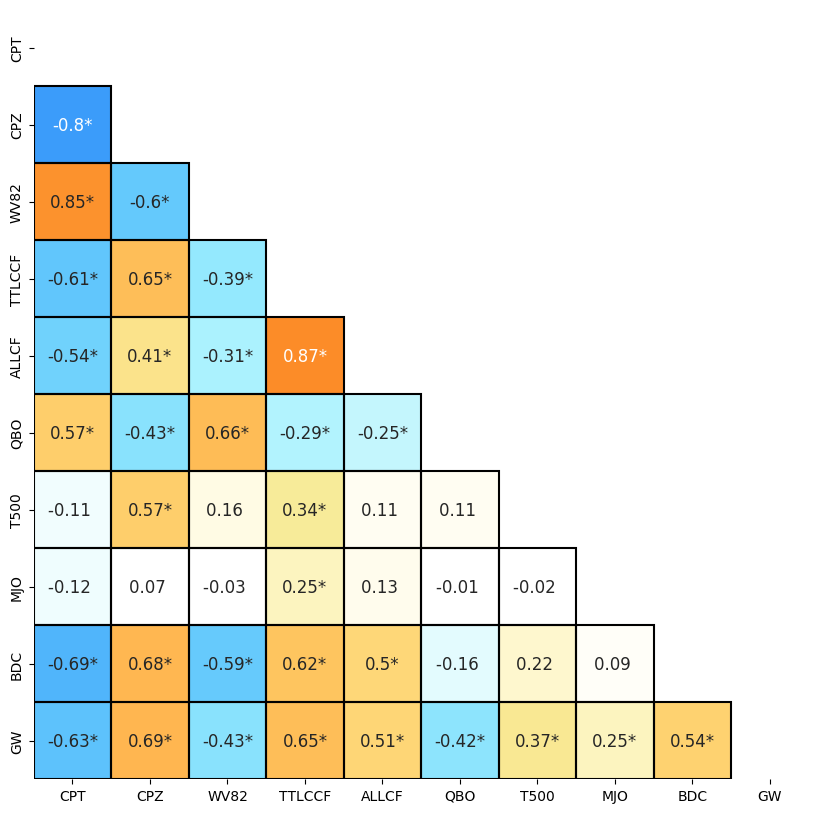

In [7]:
# Targets
cf_bw = season_finder(ttl_cirrus_cf_cal,0,1,2,10,11)[3:]
allcf_bw = season_finder(allcfTCF_cal, 0,1,2,10,11)[3:]
cpt_bw = season_finder(cpt_cal, 0,1,2,10,11)[3:]
cpz_bw = season_finder(cpz_cal, 0,1,2,10,11)[3:]
wv_bw = season_finder(wv_100hpa_cal, 0,1,2,10,11)[3:]
dc_bw = season_finder(opaque_tropical_mean, 0,1,2,10,11)[3:]

# Predictors
mjo_bw = season_finder(mjo_cal, 0,1,2,10,11)[3:]
enso_bw = season_finder(enso_cal, 0,1,2,10,11)[3:]
qbo_bw = season_finder(qbo_cal, 0,1,2,10,11)[3:]
bdc_bw = season_finder(bdc_cal, 0,1,2,10,11)[3:]
gw_bw = season_finder(gw_cal, 0,1,2,10,11)[3:]
wy_bw = season_finder(wy_cal, 0,1,2,10,11)[3:]

predictors_and_target_original = [cpt_bw, cpz_bw, wv_bw, cf_bw, allcf_bw, qbo_bw, enso_bw, mjo_bw, bdc_bw, gw_bw]
predictors_and_target = [predictors_and_target_original[i]/np.nanstd(predictors_and_target_original[i]) for i in range(len(predictors_and_target_original))]
predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                        columns=['CPT','CPZ', 'WV82', 'TTLCCF', 'ALLCF', 'QBO', 'T500', 
                                                 'MJO', 'BDC', 'GW'])

# Create Correlation and Siginficance Matrices                                                                               
corr_matrix = correlation_matrix_creator(predictors_and_target_df)
# Plot correlation Matrix
heatmap = corr_matrix_plotter(corr_matrix)

# Create Linear Regression Models    
X = predictors_and_target_df[['QBO', 'BDC', 'T500','MJO', 'GW']]
Y1 = predictors_and_target_df['CPT']
Y2 = predictors_and_target_df['TTLCCF']
Y3 = predictors_and_target_df['WV82']
Y4 = predictors_and_target_df['ALLCF']
Y5 = predictors_and_target_df['CPZ']
lr_table(X, Y1, Y2, Y3, Y4, Y5)

djf_predictors_and_target_df = predictors_and_target_df

# MLR Test
#test = predictors_and_target_df[['QBO', 'BDC']]
#lm = pg.linear_regression(test, Y2, add_intercept=True, relimp=True)
#lm = lm[['names', 'coef', 'r2', 'adj_r2', 'relimp']]
#display(lm)


In [18]:
def season_finder_maps(calendar, m1, m2, m3, m4, m5):
    """ 
    Data should be indexed as (years, months)
    """
    total_djf_anoms_list = [calendar[:,m1], calendar[:,m2], 
                            calendar[:,m3], calendar[:,m4],
                            calendar[:,m5]]
    total_djf_anoms = np.swapaxes(total_djf_anoms_list, 0,1)
    shape = np.shape(total_djf_anoms)
    total_djf_timeseries = np.reshape(total_djf_anoms, (shape[0]*shape[1],shape[2], shape[3]))
    return(total_djf_timeseries)

cpt_bw = season_finder(cpt_cal,  0,1,2,10,11)[3:]
qbo_season = season_finder(qbo_cal, 0,1,2,10,11)[3:]
RO_monthly_mean_maps = np.load('/home/bdc2/aodhan/ROM_SAF/ROM_SAF_zm_monthlymean_092002_062022.npy')[5:-2]
RO_anomaly_maps = RO_monthly_mean_maps - np.nanmean(RO_monthly_mean_maps, axis=0)
global_temp_anoms = np.reshape(RO_anomaly_maps, (np.shape(RO_anomaly_maps)[0]*np.shape(RO_anomaly_maps)[1], 
                                             np.shape(RO_anomaly_maps)[2], np.shape(RO_anomaly_maps)[3]))
global_temp_anoms_cal = np.reshape(global_temp_anoms, (15,12,36,301))
global_temp_anoms_bw = season_finder_maps(global_temp_anoms_cal, 0,1,2,10,11)[3:]

global_u_anoms_bw = season_finder_maps(u_cal, 0,1,2,10,11)[3:]


(12, 181)


/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Text(0.5, 0, 'Latitude')

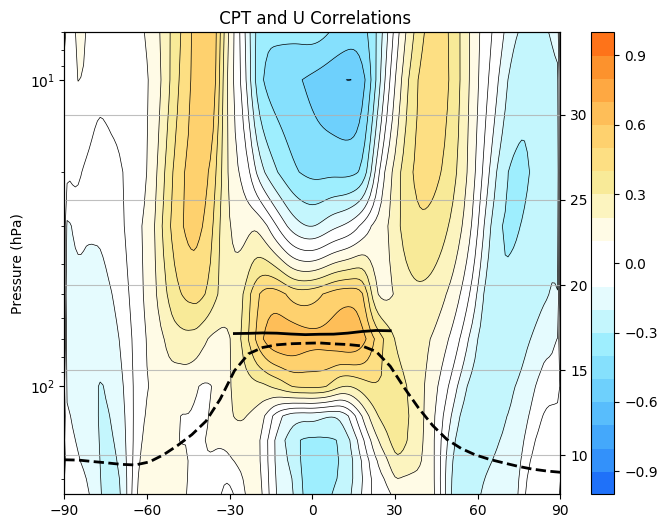

In [12]:
def press2alt(press):
    H = 7.
    altitude = -1*H*np.log(press/1013)
    return altitude


cpt_ts = cpt_bw#np.reshape(cpt_cal, (180))[5:]
#u_ts = np.reshape(u_cal, (180,12,181))[5:]

cpz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/cpz_maps_zm_annual_mean.npy')
lrz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/lrz_maps_zm_annual_mean.npy')
levels = np.linspace(-1,1,21)
corr_map = []
global_temp_anoms_ts = global_u_anoms_bw
for x in range(len(global_u_anoms_bw[0,:,0])):
    row = []
    for y in range(len(global_u_anoms_bw[0,0,:])):
        temp_ts = global_u_anoms_bw[:,x,y]
        linregress = stats.linregress(qbo_season, temp_ts)
        recreation = linregress[1] + linregress[0]*qbo_season
        temp_ts_adj = temp_ts #- recreation
        corr = stats.pearsonr(cpt_ts, temp_ts_adj)[0]
        row.append(corr)
    corr_map.append(row)
print(np.shape(corr_map))
pressures = np.array([7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225])
latitudes_u = np.linspace(-90,90,181)
fig, axs = plt.subplots(1,1, figsize=(8,6))
im = plt.contourf(latitudes_u, pressures, corr_map, levels=levels, cmap=custom_cmap)
axs.contour(latitudes_u, pressures, corr_map, levels=levels, cmap=custom_cmap)
axs.contour(latitudes_u, pressures, corr_map, levels=levels, colors='black', 
            linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
axs.set_ylim(axs.get_ylim()[::-1])
axs.set_yscale('log')
naned_cyclic_cal = np.array(corr_map).copy()
naned_cyclic_cal[:] = np.nan
ax2 = axs.twinx()
pressures_as_alts = press2alt(np.array(pressures))
ax2.contourf(latitudes_u, pressures_as_alts, naned_cyclic_cal)
ax2.set_xticks([-90,-60,-30,0,30,60,90])
ax2.grid(alpha=0.8)
ax2.plot(np.linspace(-90,90,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
ax2.plot(np.linspace(-90,90,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
plt.colorbar(im)
plt.title(' CPT and U Correlations')
axs.set_ylabel('Pressure (hPa)')
plt.xlabel('Latitude')
#plt.grid(alpha=0.8)

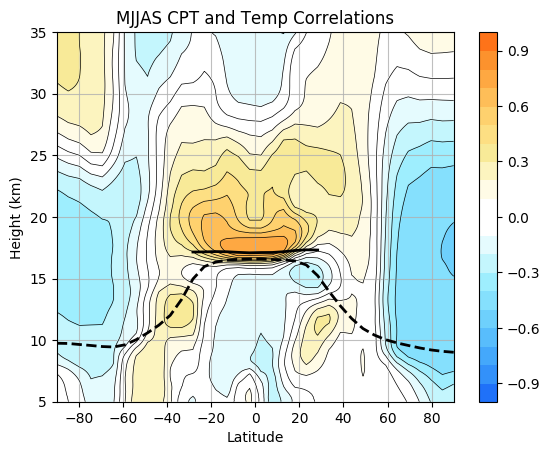

In [19]:
cpz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/cpz_maps_zm_annual_mean.npy')
lrz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/lrz_maps_zm_annual_mean.npy')
levels = np.linspace(-1,1,21)
corr_map = []
global_temp_anoms_ts = global_temp_anoms_bw
cpt_ts = cpt_bw
for x in range(len(global_temp_anoms_ts[0,:,0])):
    row = []
    for y in range(len(global_temp_anoms_ts[0,0,:])):
        temp_ts = global_temp_anoms_ts[:,x,y]
        linregress = stats.linregress(qbo_season, temp_ts)
        recreation = linregress[1] + linregress[0]*qbo_season
        temp_ts_adj = temp_ts - recreation
        corr = stats.pearsonr(cpt_ts, temp_ts_adj)[0]
        row.append(corr)
    corr_map.append(row)
im = plt.contourf(np.linspace(-90,90,36), np.linspace(5,35,301), np.transpose(corr_map), levels=levels, cmap=custom_cmap)
plt.contour(np.linspace(-90,90,36), np.linspace(5,35,301), np.transpose(corr_map), levels=levels, cmap=custom_cmap)
plt.contour(np.linspace(-90,90,36), np.linspace(5,35,301), np.transpose(corr_map), levels=levels, colors='black', 
            linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
plt.plot(np.linspace(-90,90,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
plt.plot(np.linspace(-90,90,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
plt.colorbar(im)
plt.title('MJJAS CPT and Temp Correlations')
plt.ylabel('Height (km)')
plt.xlabel('Latitude')
plt.grid(alpha=0.8)

# Mar-Apr-May

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


\begin{tabular}{llllrr}
\toprule
        &       QBO  &       BDC  &     ENSO  &   R2 &  adj R2 \\
\midrule
  CPT   &  0.52/0.29 & -0.33/0.06 & 0.06/0.01 & 0.66 &    0.64 \\
  CPZ   & -0.16/0.06 &  0.27/0.07 &  0.48/0.3 & 0.77 &    0.75 \\
   WV   &  0.63/0.31 & -0.17/0.01 & 0.44/0.21 & 0.60 &    0.57 \\
  TCF   & -0.36/0.12 &  0.34/0.08 & 0.19/0.05 & 0.47 &    0.43 \\
  ACF   & -0.54/0.23 &  0.35/0.01 & -0.01/0.0 & 0.39 &    0.34 \\
\bottomrule
\end{tabular}



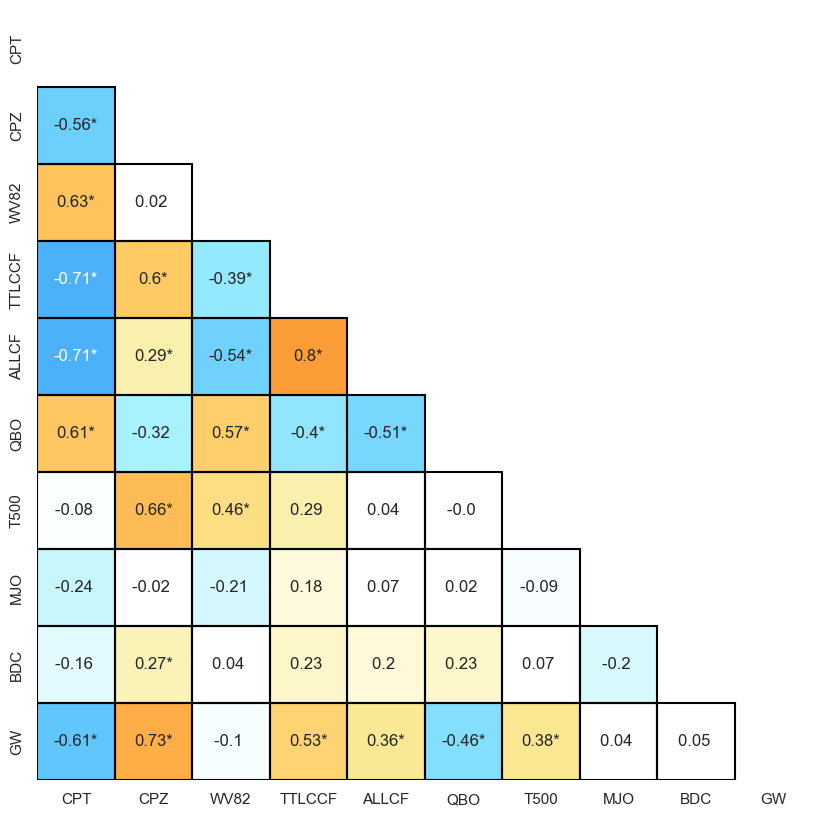

In [22]:
# Targets
cf_bw = season_finder(ttl_cirrus_cf_cal,4,5,6,7,8)[1:]
allcf_bw = season_finder(allcfTCF_cal, 4,5,6,7,8)[1:]
cpt_bw = season_finder(cpt_cal, 4,5,6,7,8)[1:]
cpz_bw = season_finder(cpz_cal, 4,5,6,7,8)[1:]
wv_bw = season_finder(wv_100hpa_cal, 4,5,6,7,8)[1:]
dc_bw = season_finder(opaque_tropical_mean, 4,5,6,7,8)[1:]


# Predictors
mjo_bw = season_finder(mjo_cal, 4,5,6,7,8)[1:]
enso_bw = season_finder(enso_cal, 4,5,6,7,8)[1:]
qbo_bw = season_finder(qbo_cal, 4,5,6,7,8)[1:]
bdc_bw = season_finder(bdc_cal, 4,5,6,7,8)[1:]
gw_bw = season_finder(gw_cal, 4,5,6,7,8)[1:]
wy_bw = season_finder(wy_cal, 4,5,6,7,8)[1:]

predictors_and_target_original = [cpt_bw, cpz_bw, wv_bw, cf_bw, allcf_bw, qbo_bw, enso_bw, mjo_bw, bdc_bw, gw_bw]
predictors_and_target = [predictors_and_target_original[i]/np.nanstd(predictors_and_target_original[i]) for i in range(len(predictors_and_target_original))]
predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                        columns=['CPT','CPZ', 'WV82', 'TTLCCF', 'ALLCF', 'QBO', 'T500', 
                                                 'MJO', 'BDC', 'GW'])

# Create Correlation and Siginficance Matrices                                                                               
corr_matrix = correlation_matrix_creator(predictors_and_target_df)
# Plot correlation Matrix
heatmap = corr_matrix_plotter(corr_matrix)

# Create Linear Regression Models    
X = predictors_and_target_df[['QBO', 'BDC', 'T500','MJO', 'GW']]
Y1 = predictors_and_target_df['CPT']
Y2 = predictors_and_target_df['TTLCCF']
Y3 = predictors_and_target_df['WV82']
Y4 = predictors_and_target_df['ALLCF']
Y5 = predictors_and_target_df['CPZ']
lr_table(X, Y1, Y2, Y3, Y4, Y5)

jja_predictors_and_target_df = predictors_and_target_df



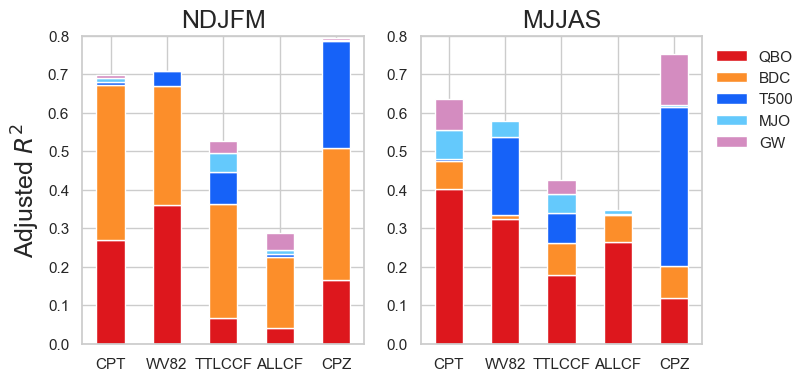

In [35]:

seasonal_predictor_and_target_dfs = [djf_predictors_and_target_df, jja_predictors_and_target_df]

# set the figure size
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs_flat = axs.flatten()
season_strings = ['NDJFM', 'MJJAS']
for predictors_and_target_df_idx in range(0, 2):
    predictors_and_target_df = seasonal_predictor_and_target_dfs[predictors_and_target_df_idx]
    axs_obj = axs_flat[predictors_and_target_df_idx]
    # Plot correlation Matrix
    LSD = predictors_and_target_df[['QBO', 'BDC','T500', 'MJO']]
    LSD_GW = predictors_and_target_df[['QBO', 'BDC','T500', 'MJO', 'GW']]

    CPT = predictors_and_target_df['CPT']
    WV = predictors_and_target_df['WV82']
    TTLCCF = predictors_and_target_df['TTLCCF']
    AllCF = predictors_and_target_df['ALLCF']
    CPZ = predictors_and_target_df['CPZ']

    targets = [CPT, WV, TTLCCF, AllCF, CPZ]
    partitioned_variances = []
    for TargetVariable in targets:
        lm = pg.linear_regression(LSD, TargetVariable, add_intercept=True, relimp=True)
        partitioned_adjr2 = lm.relimp_perc*lm.adj_r2[0]/100
        partitioned_adjr2 = partitioned_adjr2.to_list()
        partitioned_adjr2 = partitioned_adjr2[1:]
        LSDR2 = lm.adj_r2[0].astype(float)
        lm2 = pg.linear_regression(LSD_GW, TargetVariable, add_intercept=True, relimp=True)
        LSDGWR2 = lm2.adj_r2[0].astype(float)
        GW_partitioned_r2 = LSDGWR2 - LSDR2
        partitioned_adjr2.append(GW_partitioned_r2)
        partitioned_variances.append(partitioned_adjr2)

    partitioned_variances = pd.DataFrame(partitioned_variances, 
                                        index=['CPT', 'WV82', 'TTLCCF', 'ALLCF', 'CPZ'], 
                                        columns=['QBO', 'BDC', 'T500', 'MJO', 'GW'])

    #barchart colors
    bar_colors = np.array([(221,23,29),(252,142,42),(22,98,248),  (100,201,252), (212,140,192)])/255
    sequential_colors = sns.color_palette(bar_colors, 5)

    # sum of total explained variance (equal to models R2)
    total = np.nansum(partitioned_variances, axis=1,)

    #create stacked bar chart
    if predictors_and_target_df_idx == 0:
        partitioned_variances.plot(kind='bar', stacked=True, color=sequential_colors, rot=0, ax=axs_obj, legend=False)
        axs_obj.set_ylabel('Adjusted $R^{2}$', fontsize=18)
    else:
        partitioned_variances.plot(kind='bar', stacked=True, color=sequential_colors, rot=0, ax=axs_obj, legend=True)
    axs_obj.set_ylim(0,0.8)

    axs_obj.set_title(season_strings[predictors_and_target_df_idx], fontsize=18)
    axs_obj.grid(alpha=1)

axs_obj.legend(loc='upper left', bbox_to_anchor=(1., 1.0), frameon=False)





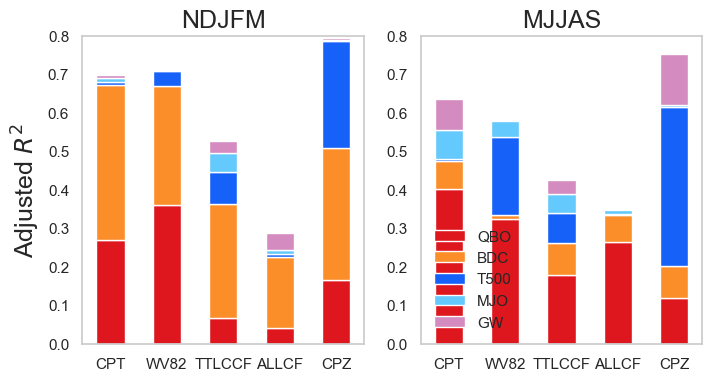

In [25]:

seasonal_predictor_and_target_dfs = [djf_predictors_and_target_df, jja_predictors_and_target_df]

# set the figure size
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs_flat = axs.flatten()
season_strings = ['NDJFM', 'MJJAS']
for predictors_and_target_df_idx in range(0, 2):
    predictors_and_target_df = seasonal_predictor_and_target_dfs[predictors_and_target_df_idx]
    axs_obj = axs_flat[predictors_and_target_df_idx]
    # Plot correlation Matrix
    LSD = predictors_and_target_df[['QBO', 'BDC','T500', 'MJO']]
    LSD_GW = predictors_and_target_df[['QBO', 'BDC','T500', 'MJO', 'GW']]

    CPT = predictors_and_target_df['CPT']
    WV = predictors_and_target_df['WV82']
    TTLCCF = predictors_and_target_df['TTLCCF']
    AllCF = predictors_and_target_df['ALLCF']
    CPZ = predictors_and_target_df['CPZ']

    targets = [CPT, WV, TTLCCF, AllCF, CPZ]
    partitioned_variances = []
    for TargetVariable in targets:
        lm = pg.linear_regression(LSD, TargetVariable, add_intercept=True, relimp=True)
        partitioned_adjr2 = lm.relimp_perc*lm.adj_r2[0]/100
        partitioned_adjr2 = partitioned_adjr2.to_list()
        partitioned_adjr2 = partitioned_adjr2[1:]
        LSDR2 = lm.adj_r2[0].astype(float)
        lm2 = pg.linear_regression(LSD_GW, TargetVariable, add_intercept=True, relimp=True)
        LSDGWR2 = lm2.adj_r2[0].astype(float)
        GW_partitioned_r2 = LSDGWR2 - LSDR2
        partitioned_adjr2.append(GW_partitioned_r2)
        partitioned_variances.append(partitioned_adjr2)

    partitioned_variances = pd.DataFrame(partitioned_variances, 
                                        index=['CPT', 'WV82', 'TTLCCF', 'ALLCF', 'CPZ'], 
                                        columns=['QBO', 'BDC', 'T500', 'MJO', 'GW'])

    #barchart colors
    bar_colors = np.array([(221,23,29),(252,142,42),(22,98,248),  (100,201,252), (212,140,192)])/255
    sequential_colors = sns.color_palette(bar_colors, 5)

    # sum of total explained variance (equal to models R2)
    total = np.nansum(partitioned_variances, axis=1,)

    #create stacked bar chart
    if predictors_and_target_df_idx == 0:
        partitioned_variances.plot(kind='bar', stacked=True, color=sequential_colors, rot=0, ax=axs_obj, legend=False)
        axs_obj.set_ylabel('Adjusted $R^{2}$', fontsize=18)
    else:
        partitioned_variances.plot(kind='bar', stacked=True, color=sequential_colors, rot=0, ax=axs_obj, legend=True)
    axs_obj.set_ylim(0,0.8)

    axs_obj.set_title(season_strings[predictors_and_target_df_idx], fontsize=18)
    axs_obj.grid()

sns.set(style="whitegrid")
#plt.tight_layout()
plt.legend(frameon=False)




# Jun-Jul-Aug-Sep with Convection

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


\begin{tabular}{llllrr}
\toprule
        &       QBO  &       BDC  &      ENSO  &   R2 &  adj R2 \\
\midrule
   CPT  &  0.53/0.27 & -0.16/0.02 & -0.12/0.08 & 0.55 &    0.50 \\
 TTL CF & -0.27/0.12 &  0.13/0.03 & -0.08/0.05 & 0.64 &    0.60 \\
   WV   &  0.64/0.28 & -0.03/0.01 &  0.54/0.12 & 0.46 &    0.41 \\
\bottomrule
\end{tabular}



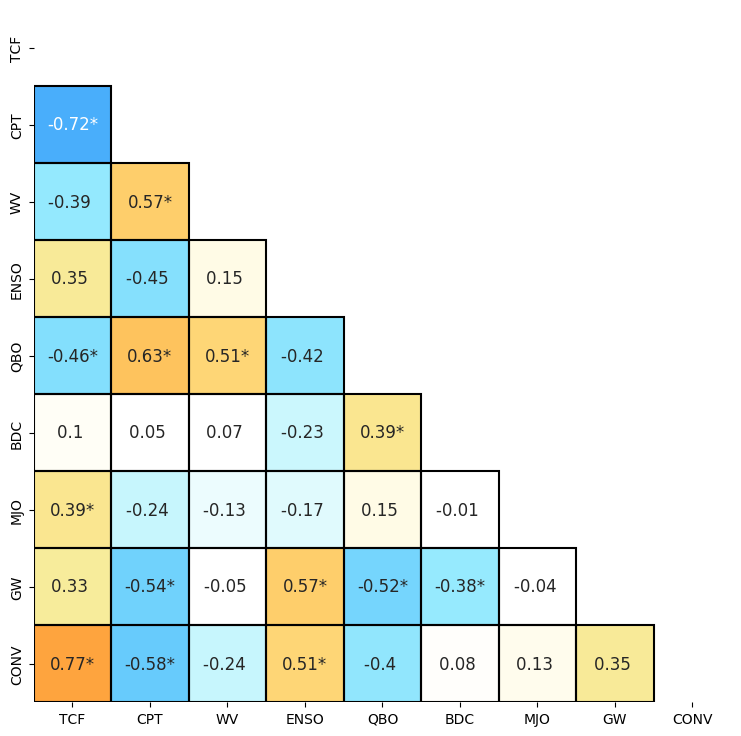

In [72]:
# Targets
cf_bs = season_finder(ttl_cirrus_cf_cal,5,6,7,8)
cpt_bs = season_finder(cpt_cal, 5,6,7,8)
wv_bs = season_finder(wv_100hpa_cal, 5,6,7,8)

# Predictors
mjo_bs = season_finder(mjo_cal, 5,6,7,8)
enso_bs = season_finder(enso_cal, 5,6,7,8)
qbo_bs = season_finder(qbo_cal, 5,6,7,8)
bdc_bs = season_finder(bdc_cal, 5,6,7,8)
gw_bs = season_finder(gw_cal, 5,6,7,8)
wy_bs = season_finder(wy_cal, 5,6,7,8)
conv_bs = season_finder(sat_conv_cal[:,:,40], 5,6,7,8)

predictors_and_target_original = [cf_bs, cpt_bs, wv_bs, enso_bs, qbo_bs, bdc_bs, mjo_bs, gw_bs]
predictors_and_target_original = np.array(predictors_and_target_original)[:,:44]
predictors_and_target_original = np.append(predictors_and_target_original, [conv_bs], axis=0)
predictors_and_target = [predictors_and_target_original[i]/np.nanstd(predictors_and_target_original[i]) for i in range(len(predictors_and_target_original))]
predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                        columns=['TCF', 'CPT', 'WV', 'ENSO', 'QBO', 
                                                 'BDC',  'MJO', 'GW', 'CONV'])

# Create Correlation and Siginficance Matrices                                                                               
corr_matrix = correlation_matrix_creator(predictors_and_target_df)
# Plot correlation Matrix
heatmap = corr_matrix_plotter(corr_matrix)

# Create Linear Regression Models    
X = predictors_and_target_df[['QBO', 'BDC', 'ENSO', 'CONV']]
Y1 = predictors_and_target_df['CPT']
Y2 = predictors_and_target_df['TCF']
Y3 = predictors_and_target_df['WV']
lr_table(X, Y1, Y2, Y3)
    
#dfi.export(lm,'../figures/CPT_15NS_LSD_GW')
#display(lm.round(3))
#fig = heatmap.get_figure()
#fig.savefig("../figures/correlation_15NS", dpi=300) 


42
\begin{tabular}{llllrr}
\toprule
        &       QBO  &       BDC  &     ENSO  &   R2 &  adj R2 \\
\midrule
   CPT  &   0.5/0.31 & -0.56/0.35 & 0.18/0.03 & 0.75 &    0.73 \\
 TTL CF & -0.48/0.22 &  0.44/0.21 & 0.29/0.06 & 0.59 &    0.54 \\
   WV   &  0.48/0.29 & -0.52/0.31 &  0.31/0.1 & 0.71 &    0.68 \\
\bottomrule
\end{tabular}



/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


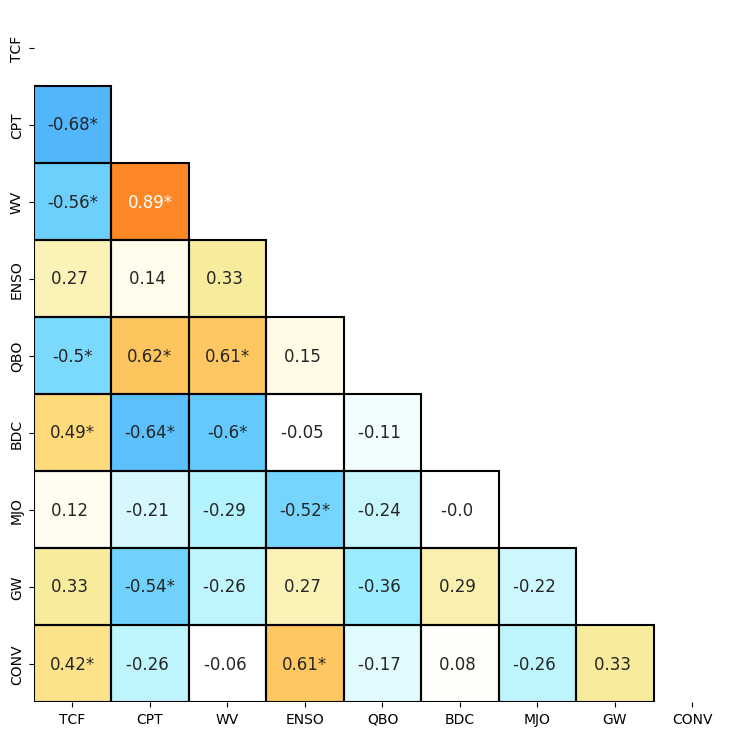

In [77]:
# Targets
cf_trans = season_finder(ttl_cirrus_cf_cal,3,4,9,10)[2:]
cpt_trans = season_finder(cpt_cal,3,4,9,10)[2:]
wv_trans = season_finder(wv_100hpa_cal,3,4,9,10)[2:]

# Predictors
mjo_trans = season_finder(mjo_cal,3,4,9,10)[2:]
enso_trans = season_finder(enso_cal,3,4,9,10)[2:]
qbo_trans = season_finder(qbo_cal,3,4,9,10)[2:]
bdc_trans = season_finder(bdc_cal,3,4,9,10)[2:]
gw_trans = season_finder(gw_cal,3,4,9,10)[2:]
wy_trans = season_finder(wy_cal,3,4,9,10)[2:]
conv_trans = season_finder(sat_conv_cal[:,:,40],3,4,9,10)[2:]
print(len(conv_trans))
predictors_and_target_original = [cf_trans, cpt_trans, wv_trans, enso_trans, qbo_trans, bdc_trans, mjo_trans, gw_trans]
predictors_and_target_original = np.array(predictors_and_target_original)[:,:42]
predictors_and_target_original = np.append(predictors_and_target_original, [conv_trans], axis=0)
predictors_and_target = [predictors_and_target_original[i]/np.nanstd(predictors_and_target_original[i]) for i in range(len(predictors_and_target_original))]
predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                        columns=['TCF', 'CPT', 'WV', 'ENSO', 'QBO', 
                                                 'BDC',  'MJO', 'GW', 'CONV'])

# Create Correlation and Siginficance Matrices                                                                               
corr_matrix = correlation_matrix_creator(predictors_and_target_df)
# Plot correlation Matrix
heatmap = corr_matrix_plotter(corr_matrix)

# Create Linear Regression Models    
X = predictors_and_target_df[['QBO', 'BDC', 'ENSO', 'CONV']]
Y1 = predictors_and_target_df['CPT']
Y2 = predictors_and_target_df['TCF']
Y3 = predictors_and_target_df['WV']
lr_table(X, Y1, Y2, Y3)
    
#dfi.export(lm,'../figures/CPT_15NS_LSD_GW')
#display(lm.round(3))
#fig = heatmap.get_figure()
#fig.savefig("../figures/correlation_15NS", dpi=300) 
